## EDA -- Step 1
### Ground Truth
#### Bounding Boxes on Videos

In [1]:
import pandas as pd
import numpy as np
import cv2
import time
import os
import random
import yaml

## Dataset Files:
1. Objects
2. Events
3. Mapping

## Objects

### Get Data

In [2]:
# function to preprocess 'objects.txt' files to desired minimal dataframe

def objects_to_boxes(path, columns):
    """takes an 'object.txt' path and list of column names,
    returns minimal df for drawing boxes,
    with columns ['frame', 'x_min', 'x_max', 'y_min', 'y_max']"""
    
    # read in data
    df_boxes = pd.read_csv(path, sep=" ", names=columns, index_col=False)
    
    # modify data to specifications
            # currently hard-coded for '.objects.txt' files. Modify next line for flexibility.
    df_boxes.drop(['Object_ID', 'Duration', 'Object_Type'], axis=1, inplace=True)
    df_boxes['bbox_width'] = df_boxes['bbox_lefttop_x'] + df_boxes['bbox_width']
    df_boxes['bbox_height'] = df_boxes['bbox_lefttop_y'] + df_boxes['bbox_height']

    # rename columns
    col_names = {'Current_Frame':'frame', 
                 'bbox_lefttop_x':'x_min', 
                 'bbox_width':'x_max', 
                 'bbox_lefttop_y':'y_min', 
                 'bbox_height':'y_max'}
    df_boxes.rename(columns=col_names, inplace=True)
    
    return df_boxes

In [3]:
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']
object_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/\
VIRAT_S_000001.viratdata.objects.txt'
df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)

In [4]:
df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
df_boxes = objects_to_boxes(path=object_path, columns=object_columns)

In [5]:
df_obj.head(5)

Object_ID  Duration  Current_Frame  bbox_lefttop_x  bbox_lefttop_y   
0          1       385           3455               1             663  \
1          1       385           3456               1             663   
2          1       385           3457               1             663   
3          1       385           3458               1             663   
4          1       385           3459               1             663   

   bbox_width  bbox_height  Object_Type  
0          76          132            1  
1          76          132            1  
2          76          132            1  
3          76          132            1  
4          76          132            1

In [6]:
df_boxes.head(5)

frame  x_min  y_min  x_max  y_max
0   3455      1    663     77    795
1   3456      1    663     77    795
2   3457      1    663     77    795
3   3458      1    663     77    795
4   3459      1    663     77    795

### Draw Bounding Boxes

    * 1080p resolution means the image has 1920 pixels horizontally by 1080 vertically (1920x1080)
- bbox lefttop x (horizontal x coordinate of the left top of bbox, origin is lefttop of the frame)
- bbox lefttop y (vertical y coordinate of the left top of bbox, origin is lefttop of the frame)
- bbox width (horizontal width of the bbox)
- bbox height (vertical height of the bbox)

In [7]:
# Function to draw bounding boxes

def draw_bounding_boxes(frame, boxes, color=(0, 255, 0), thickness=2):
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, thickness)
    return frame

In [8]:
# Function to end the playback sequence

def end_sequence(cap):
    # Release Video Capture
    cap.release()

    # Close cv2 window
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1); # mac needs 4 loops of .waitKey(1) to to destroy windows..

In [9]:
# Process frames
def playback_with_boxes(path, data):
    print("Press 'q' to quit playback")
    
    # open Video Capture object
    cap = cv2.VideoCapture(path)

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        frame_boxes = data[data['frame'] == frame_number][['x_min', 'y_min', 'x_max', 'y_max']].values

        # Draw bounding boxes on the frame
        frame_with_boxes = draw_bounding_boxes(frame, frame_boxes)

        # Display the frame
        cv2.imshow('Video with Bounding Boxes', frame_with_boxes)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            end_sequence(cap)
            break
    # end
    end_sequence(cap)

In [10]:
video_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/\
VIRAT_S_000001.mp4'

In [11]:
# check that our video and objects.txt align
print(video_path.split('/')[-1])
print(object_path.split('/')[-1])

VIRAT_S_000001.mp4
VIRAT_S_000001.viratdata.objects.txt


### View Video with Bounding Boxes (First Attempt)

In [12]:
# play the video with bounding boxes

playback_with_boxes(path=video_path, data=df_boxes)

Press 'q' to quit playback


### Explore what we saw in playback

#### File: VIRAT_S_000001.mp4

There seem to be extra bounding boxes persisting throughout... 
let's check our dataset again

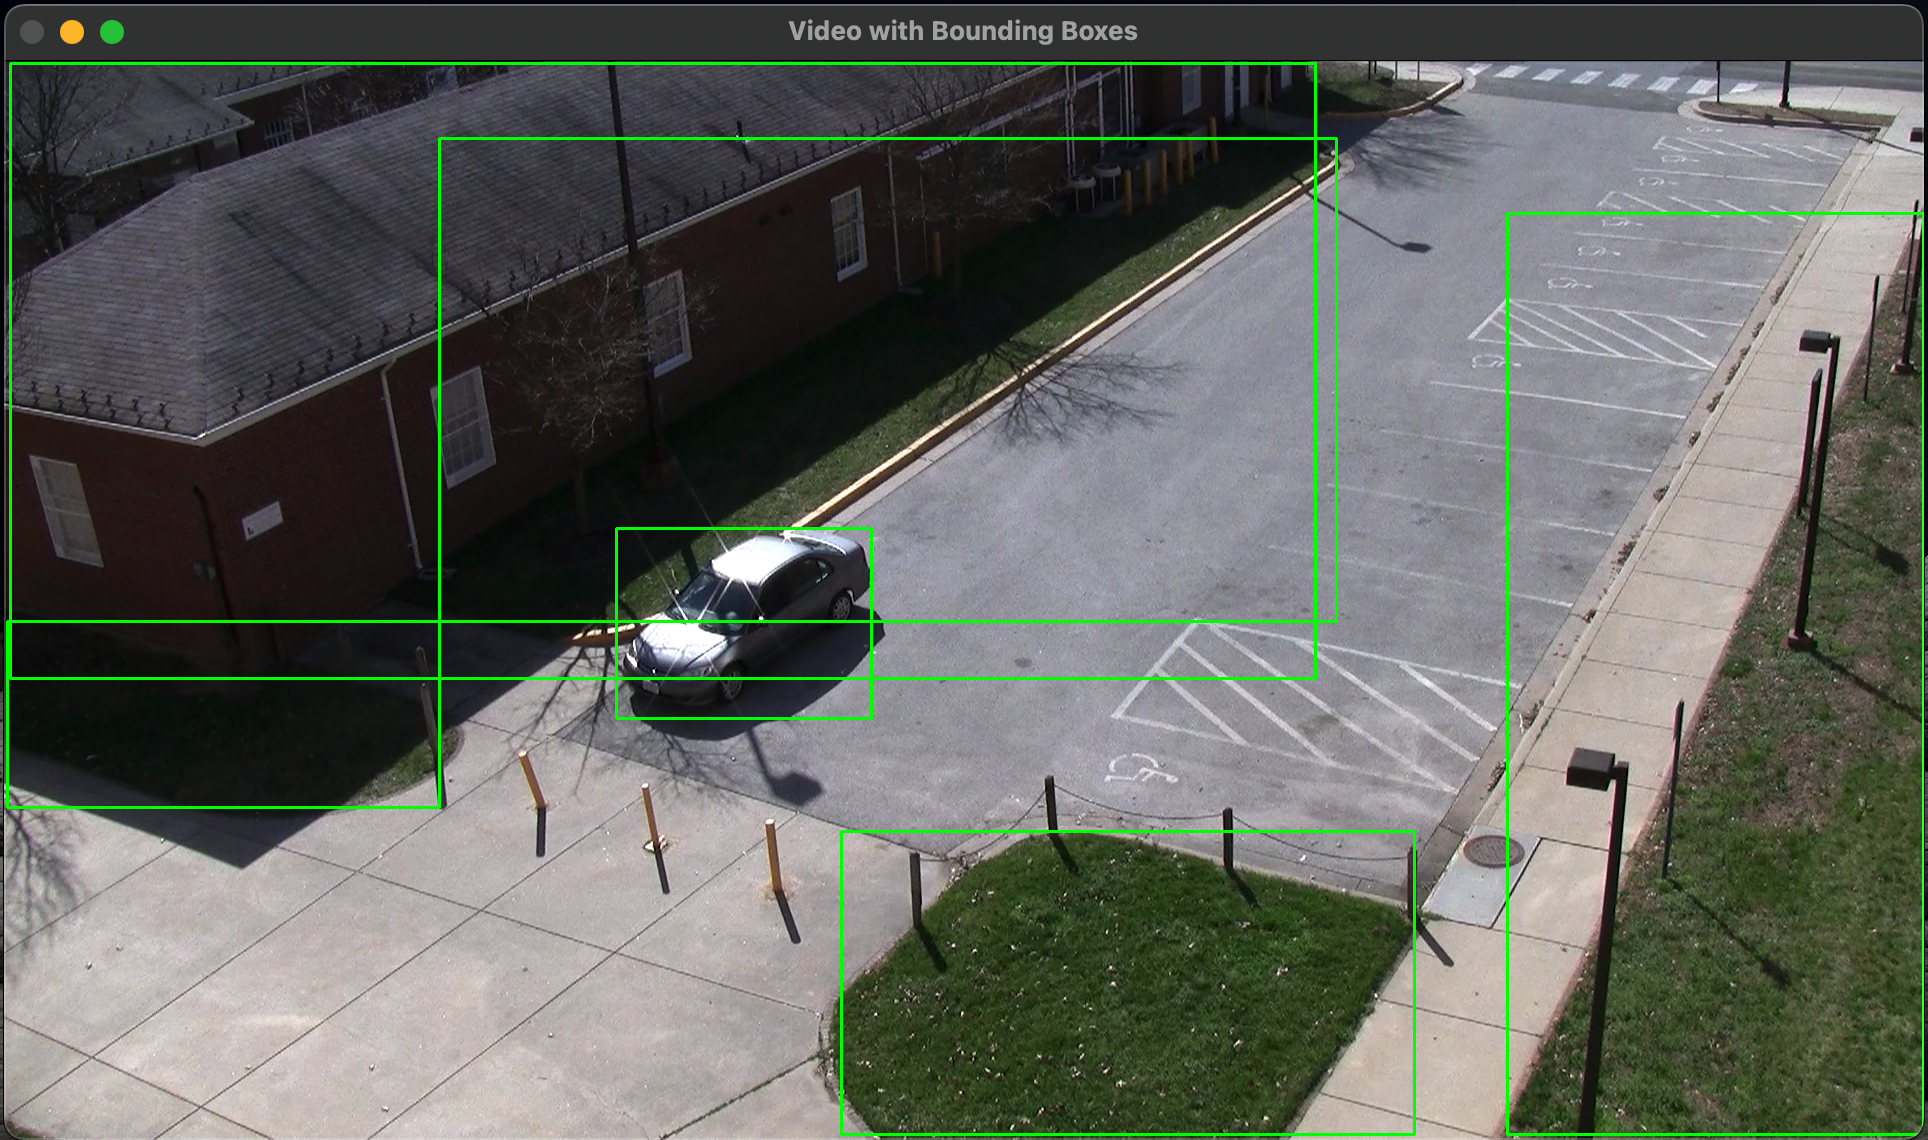

In [13]:
# show df_obj for first frames
df_obj.sort_values(by=['Current_Frame']).reset_index()[:14]

index  Object_ID  Duration  Current_Frame  bbox_lefttop_x   
0      385          3      4732              0             613  \
1   199326         31     20656              0             435   
2   158124         29     20656              0            1503   
3    96156         26     20656              0               6   
4   137468         28     20656              0             837   
5   116812         27     20656              0               3   
6   199327         31     20656              1             435   
7      386          3      4732              1             612   
8   158125         29     20656              1            1503   
9   116813         27     20656              1               3   
10  137469         28     20656              1             837   
11   96157         26     20656              1               6   
12  116814         27     20656              2               3   
13  199328         31     20656              2             435   

    bbox_lefttop_y  bbox_width  bbox_height  Object_Type  
0              469         254          189            2  
1               78         897          483            0  
2              153         416          921            0  
3                3        1305          615            0  
4              771         573          303            0  
5              561         432          186            0  
6               78         897          483            0  
7              468         255          190            2  
8              153         416          921            0  
9              561         432          186            0  
10             771         573          303            0  
11               3        1305          615            0  
12             561         432          186            0  
13              78         897          483            0

## Q1: How many 'Object_Type' == 0 objects? What do they look like? How long is their duration?

from readme:

Object Type ID (for column 8 above for object files)

1. person
2. car (usually passenger vehicles such as sedan, truck)
3. vehicles (vehicles other than usual passenger cars. Examples include construction vehicles)
4. object (neither car or person, usually carried objects)
5. bike, bicylces (may include engine-powered auto-bikes)

It appears that Object_Type == 0 is not an accounted-for object

#### A1: Let's see

In [14]:
# what are our type == 0 objects?
type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
type0_objs

array([26, 27, 28, 29, 30, 31])

In [15]:
# Function to display image (frame in middle of 'Duration')
# with bounding box of specific object
def display_this_object(obj, df, path=video_path, color=(0, 255, 0), thickness=2):
    """takes Object_ID, video path and full object dataframe,
    displays a single image with bounding box
    from first appearance of object in video"""
    
    # Get index of the middle frame of this object
    start_idx = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T.index.values[0]
    half_dur = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T['Duration'].values[0] * 0.5
    idx = int(half_dur + start_idx)
    # ALT:
    # uncomment for first frame
    ###idx = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T.index.values[0]
    
    # Get Bounding Box coordinates
    x_min = df['bbox_lefttop_x'][idx]
    y_min = df['bbox_lefttop_y'][idx]
    x_max = df['bbox_lefttop_x'][idx] + df['bbox_width'][idx]
    y_max = df['bbox_lefttop_y'][idx] + df['bbox_height'][idx]
    
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # set frame position
    frame_index = df.iloc[idx]['Current_Frame']
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the Frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the frame")
        return
    if ret:
        # Draw bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, thickness)

        # Display the frame
        print("Object_ID: ", obj)
        print("Current_Frame: ", frame_index)
        cv2.imwrite("frame%i.jpg"%frame_index, frame)
        image = cv2.imread("frame%i.jpg"%frame_index)
        cv2.imshow("Object {} -- Frame {}".format(obj, frame_index), image)

        cv2.waitKey(3000) # wait 5 seconds

        # Delete the image
        if os.path.exists("frame%i.jpg"%frame_index):
            os.remove("frame%i.jpg"%frame_index)

        end_sequence(cap) # Terminate all windows

        return

View the data we are about to pass, then view the objects specified

In [16]:
video_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000001.mp4'
video_path

'/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000001.mp4'

In [17]:
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']
object_path = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/\
VIRAT_S_000001.viratdata.objects.txt'
df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
df_obj.head(2)

Object_ID  Duration  Current_Frame  bbox_lefttop_x  bbox_lefttop_y   
0          1       385           3455               1             663  \
1          1       385           3456               1             663   

   bbox_width  bbox_height  Object_Type  
0          76          132            1  
1          76          132            1

In [18]:
# Display images 1 by 1 for all Objects with Type 0

for obj in type0_objs:
    display_this_object(obj, df_obj)

Object_ID:  26
Current_Frame:  10328
Object_ID:  27
Current_Frame:  10328
Object_ID:  28
Current_Frame:  10328
Object_ID:  29
Current_Frame:  10328
Object_ID:  30
Current_Frame:  10383
Object_ID:  31
Current_Frame:  10328


### Q2: What are Type-0 objects in other scenes?

### Getting all file names in lists

In [19]:
# get all video paths
all_video_paths = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original')
all_video_paths.sort()
print(all_video_paths[:10])

['VIRAT_S_000001.mp4', 'VIRAT_S_000002.mp4', 'VIRAT_S_000003.mp4', 'VIRAT_S_000004.mp4', 'VIRAT_S_000006.mp4', 'VIRAT_S_000101.mp4', 'VIRAT_S_000102.mp4', 'VIRAT_S_000200_00_000100_000171.mp4', 'VIRAT_S_000200_01_000226_000268.mp4', 'VIRAT_S_000200_02_000479_000635.mp4']


In [20]:
# get all object paths
all_object_paths = []
obj_p = os.listdir('/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations')
for string in obj_p:
    if string[-11:] == 'objects.txt':
        all_object_paths.append(string)
all_object_paths.sort()
print(all_object_paths[:10])

['VIRAT_S_000001.viratdata.objects.txt', 'VIRAT_S_000002.viratdata.objects.txt', 'VIRAT_S_000003.viratdata.objects.txt', 'VIRAT_S_000004.viratdata.objects.txt', 'VIRAT_S_000006.viratdata.objects.txt', 'VIRAT_S_000101.viratdata.objects.txt', 'VIRAT_S_000102.viratdata.objects.txt', 'VIRAT_S_000200_00_000100_000171.viratdata.objects.txt', 'VIRAT_S_000200_01_000226_000268.viratdata.objects.txt', 'VIRAT_S_000200_03_000657_000899.viratdata.objects.txt']


In [21]:
# Q: Why is the index 9 path different???
# A: There is not a 1 to 1 mapping for videos and object annotation files. 
#    i.e. some videos have no matching objects.txt file

In [22]:
len(all_video_paths)

329

In [23]:
len(all_object_paths)

315

In [24]:
# To resolve this,
# let's take the unique identifier string from the video paths and map them
# this way, we know the mapping is correct, 
# and can observe when there is no object file for a video

In [25]:
all_video_paths[0][:14]

'VIRAT_S_000001'

In [26]:
all_video_paths[7][:23]

'VIRAT_S_000200_00_00010'

In [27]:
# Map identifier strings (keys) to video and object filepaths

all_keys = {}
# first 7 videos have shorter identifier sequences
for i in range(7):
    key = all_video_paths[i][:14]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(all_object_paths)):
        if all_object_paths[j][:14] == key:
            keyed_object = all_object_paths[j]
    all_keys[key] = [keyed_video, keyed_object]
# rest are longer
for i in range(7, len(all_video_paths)):
    key = all_video_paths[i][:23]
    keyed_video = all_video_paths[i]
    keyed_object = None
    for j in range(0, len(all_object_paths)):
        if all_object_paths[j][:23] == key:
            keyed_object = all_object_paths[j]
    all_keys[key] = [keyed_video, keyed_object]

In [28]:
len(all_keys) # should be same as len(all_video_paths) (329)

329

In [29]:
# for usage, make a list of the keys
key_list = []
for key in all_keys.keys():
    key_list.append(key)

In [30]:
# cool
all_keys[key_list[8]]

['VIRAT_S_000200_01_000226_000268.mp4',
 'VIRAT_S_000200_01_000226_000268.viratdata.objects.txt']

In [31]:
# let's now count the type-0 objects for the first 5 videos:

# establish constants
vid_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/'
obj_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/'
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']

for i in range(5):
    # get video and object paths
    video_path = vid_prefix + all_keys[key_list[i]][0]
    object_path = obj_prefix + all_keys[key_list[i]][1]
    # get dataframe from object path
    df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
    # count unique values of objects with type 0
    type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
    
    # print our results
    print(object_path)
    print(type0_objs)

/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000001.viratdata.objects.txt
[26 27 28 29 30 31]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000002.viratdata.objects.txt
[14 15 16 17 18 19 20 21]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000003.viratdata.objects.txt
[15 16 17 18 19 20 21 22 23]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000004.viratdata.objects.txt
[]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000006.viratdata.objects.txt
[]


There was an error code in processing the data to a pandas DataFrame for line 115562 of the .objects.txt file for VIRAT_S_000002

Let's take a look and see what the issue in the data is:

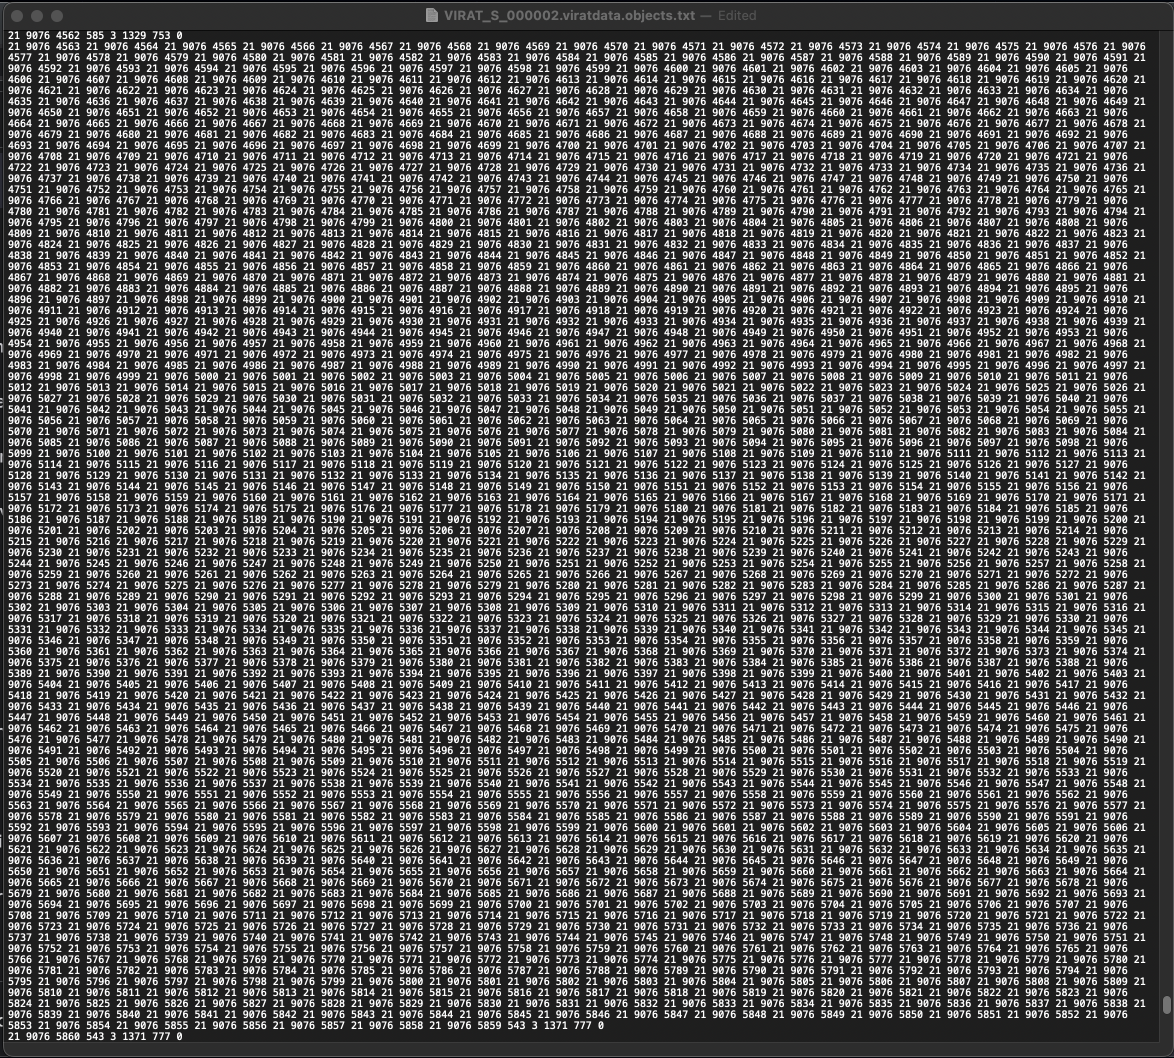

#### Discovered issue: 
Object_ID 21 of this objects.txt file is missing the last 5 columns (bbox coords, and object_id) as well as the 'Enter' key 

#### Resolution:
I'm going to remove these records, since they appear to be corrupted data. Also, the object is of type 0 and is likely to be removed for irrelevance.

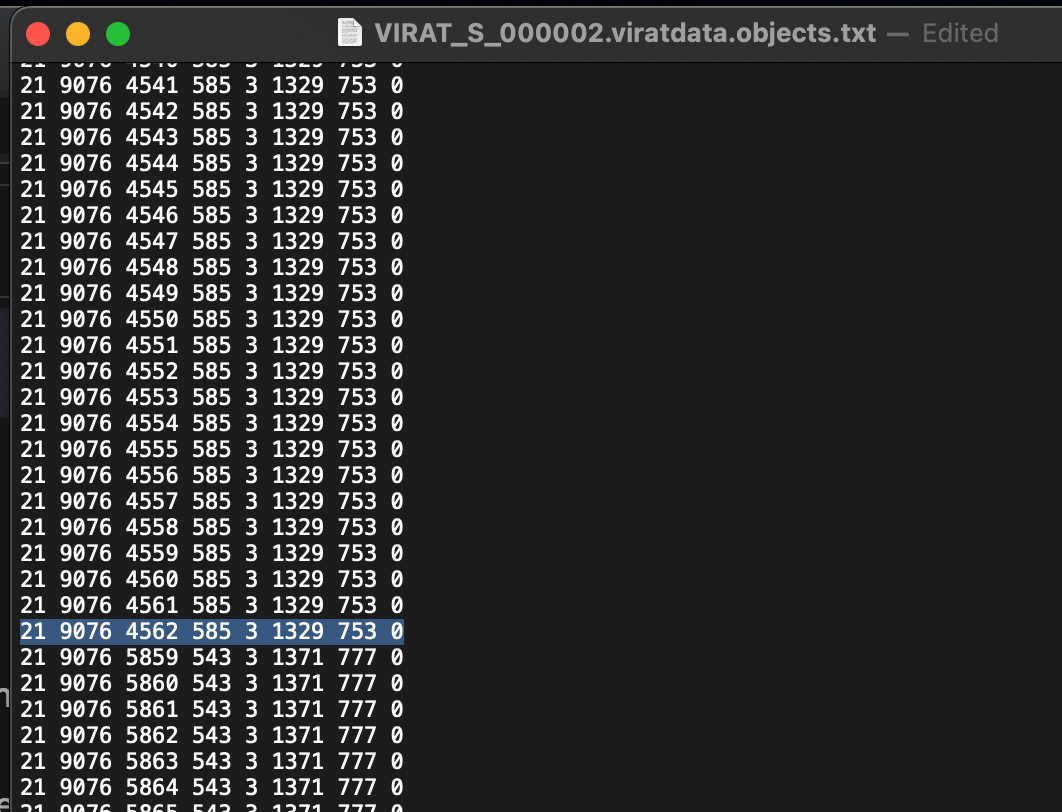

Seems fine

#### OK, trying again. Let's see how many type-0 objects there are for the first 5 videos:

In [32]:
# displaycount the type-0 objects for the first 5 videos:

# establish constants
vid_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/'
obj_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/'
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']

for i in range(5):
    # get video and object paths
    video_path = vid_prefix + all_keys[key_list[i]][0]
    object_path = obj_prefix + all_keys[key_list[i]][1]
    # get dataframe from object path
    df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
    # count unique values of objects with type 0
    type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
    
    # print our results
    print(video_path)
    print(object_path)
    print(len(type0_objs), " type-0 objects. Object_IDs: \t", type0_objs)

/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000001.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000001.viratdata.objects.txt
6  type-0 objects. Object_IDs: 	 [26 27 28 29 30 31]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000002.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000002.viratdata.objects.txt
8  type-0 objects. Object_IDs: 	 [14 15 16 17 18 19 20 21]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000003.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000003.viratdata.objects.txt
9  type-0 objects. Object_IDs: 	 [15 16 17 18 19 20 21 22 23]
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000004.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000004.viratdata.objects.txt
0  type-0 objects. Object_IDs: 	 []
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dat

### Ok, now let's see these objects

In [33]:
# Variant to display using first frame instead of middle frame

def display_this_object_ff(obj, df, path=video_path, color=(0, 255, 0), thickness=2):
    """takes Object_ID, video path and full object dataframe,
    displays a single image with bounding box
    from first appearance of object in video"""
    
    # Get index of the middle frame of this object
    ###start_idx = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T.index.values[0]
    ###half_dur = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T['Duration'].values[0] * 0.5
    ###idx = int(half_dur + start_idx)
    # ALT:
    # uncomment for first frame
    idx = pd.DataFrame(df[df['Object_ID'] == obj].iloc[0]).T.index.values[0]
    
    # Get Bounding Box coordinates
    x_min = df['bbox_lefttop_x'][idx]
    y_min = df['bbox_lefttop_y'][idx]
    x_max = df['bbox_lefttop_x'][idx] + df['bbox_width'][idx]
    y_max = df['bbox_lefttop_y'][idx] + df['bbox_height'][idx]
    
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # set the frame position
    frame_index = df.iloc[idx]['Current_Frame']
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the Frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the frame")
        return
    if ret:
        # Draw bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, thickness)

        # Display the frame
        print("Object_ID: ", obj)
        print("Current_Frame: ", frame_index)
        cv2.imwrite("frame%i.jpg"%frame_index, frame)
        image = cv2.imread("frame%i.jpg"%frame_index)
        vid_index = all_keys[key_list[i]][0].split('.')[0] # !!!! THIS BREAKS IT IF NOT IN i LOOP
        cv2.imshow("Object {} -- Frame {} -- Video {}".format(obj, frame_index, vid_index), image)

        cv2.waitKey(2000) # wait 2 seconds

        # Delete the image
        if os.path.exists("frame%i.jpg"%frame_index):
            os.remove("frame%i.jpg"%frame_index)

        end_sequence(cap) # Terminate all windows

        return

In [34]:
for i in range(2, 4):
    # get video and object paths
    video_path = vid_prefix + all_keys[key_list[i]][0]
    object_path = obj_prefix + all_keys[key_list[i]][1]
    
    # get dataframe from object path
    df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
    
    # print where we are
    print(video_path)
    print(object_path)
    
    # view these objects in turn
    type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
    for obj in type0_objs:
        display_this_object_ff(obj, df_obj)
    

/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000003.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000003.viratdata.objects.txt
Object_ID:  15
Current_Frame:  0
Object_ID:  16
Current_Frame:  0
Object_ID:  17
Current_Frame:  0
Object_ID:  18
Current_Frame:  0
Object_ID:  19
Current_Frame:  0
Object_ID:  20
Current_Frame:  0
Object_ID:  21
Current_Frame:  0
Object_ID:  22
Current_Frame:  0
Object_ID:  23
Current_Frame:  0
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/VIRAT_S_000004.mp4
/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000004.viratdata.objects.txt


### Let's count the type-0 objects for all videos
- This will also help to determine if there is more corrupted data

In [35]:
# displaycount the type-0 objects for all videos:

# establish constants
vid_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/videos_original/'
obj_prefix = '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/'
object_columns = ['Object_ID', 'Duration', 'Current_Frame', 'bbox_lefttop_x',
                  'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'Object_Type']

# store troublesome object data
corrupted = []
count = 0
type0s = []

# Do all the stuff
for i in range(len(all_video_paths)):
    # get video and object paths
    video_suffix = all_keys[key_list[i]][0]
    object_suffix = all_keys[key_list[i]][1]
    video_path = vid_prefix + video_suffix
    # if the object file doesn't exist for this video, print failure
    if object_suffix == None:
        print("*** VIDEO HAS NO MATCHED OBJECT FILE: ", video_suffix)
        count += 1
    else:
        object_path = obj_prefix + object_suffix
        try:
            # get dataframe from object path
            df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
            # list unique IDs of objects with type 0
            type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()

            # success! print our results
            print(object_suffix)
            print(len(type0_objs), "type-0 objects. Object_IDs: \t", type0_objs)
            
            # save positions of videos with type-0 objects
            if len(type0_objs) > 0:
                type0s.append(i)
        # if there was some issue with handling the data in a pandas dataframe
        except:
            print("*** FAILED TO EXTRACT DATA: ", object_suffix)
            corrupted.append(object_path)

VIRAT_S_000001.viratdata.objects.txt
6 type-0 objects. Object_IDs: 	 [26 27 28 29 30 31]
VIRAT_S_000002.viratdata.objects.txt
8 type-0 objects. Object_IDs: 	 [14 15 16 17 18 19 20 21]
VIRAT_S_000003.viratdata.objects.txt
9 type-0 objects. Object_IDs: 	 [15 16 17 18 19 20 21 22 23]
VIRAT_S_000004.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000006.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000101.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000102.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000200_00_000100_000171.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000200_01_000226_000268.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
*** VIDEO HAS NO MATCHED OBJECT FILE:  VIRAT_S_000200_02_000479_000635.mp4
VIRAT_S_000200_03_000657_000899.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_000200_04_000937_001443.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []

VIRAT_S_010107_01_000068_000196.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010107_02_000282_000312.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010108_01_000570_000718.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010108_02_000800_000960.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010109_00_000000_000063.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010109_04_000487_000538.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010109_05_000602_000678.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010109_07_000876_000910.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010109_08_000952_001011.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010110_00_000000_000021.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010110_02_000513_000566.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_010110_03_000

VIRAT_S_040001_02_001102_001530.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040001_03_001531_001595.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040002_03_001525_001569.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_00_000000_000072.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_01_000083_000193.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_02_000197_000552.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_03_000577_000741.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_04_000758_001118.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_05_001123_001437.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040003_06_001441_001518.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040004_00_000011_000093.viratdata.objects.txt
0 type-0 objects. Object_IDs: 	 []
VIRAT_S_040005_00_000

In [36]:
type0s

[0, 1, 2, 37, 302, 312, 314]

In [37]:
for i in type0s:
    print(all_video_paths[i])

VIRAT_S_000001.mp4
VIRAT_S_000002.mp4
VIRAT_S_000003.mp4
VIRAT_S_000206_07_001501_001600.mp4
VIRAT_S_050202_04_000690_000750.mp4
VIRAT_S_050203_07_001288_001531.mp4
VIRAT_S_050203_09_001960_002083.mp4


In [38]:
count

14

In [39]:
corrupted

[]

Before:

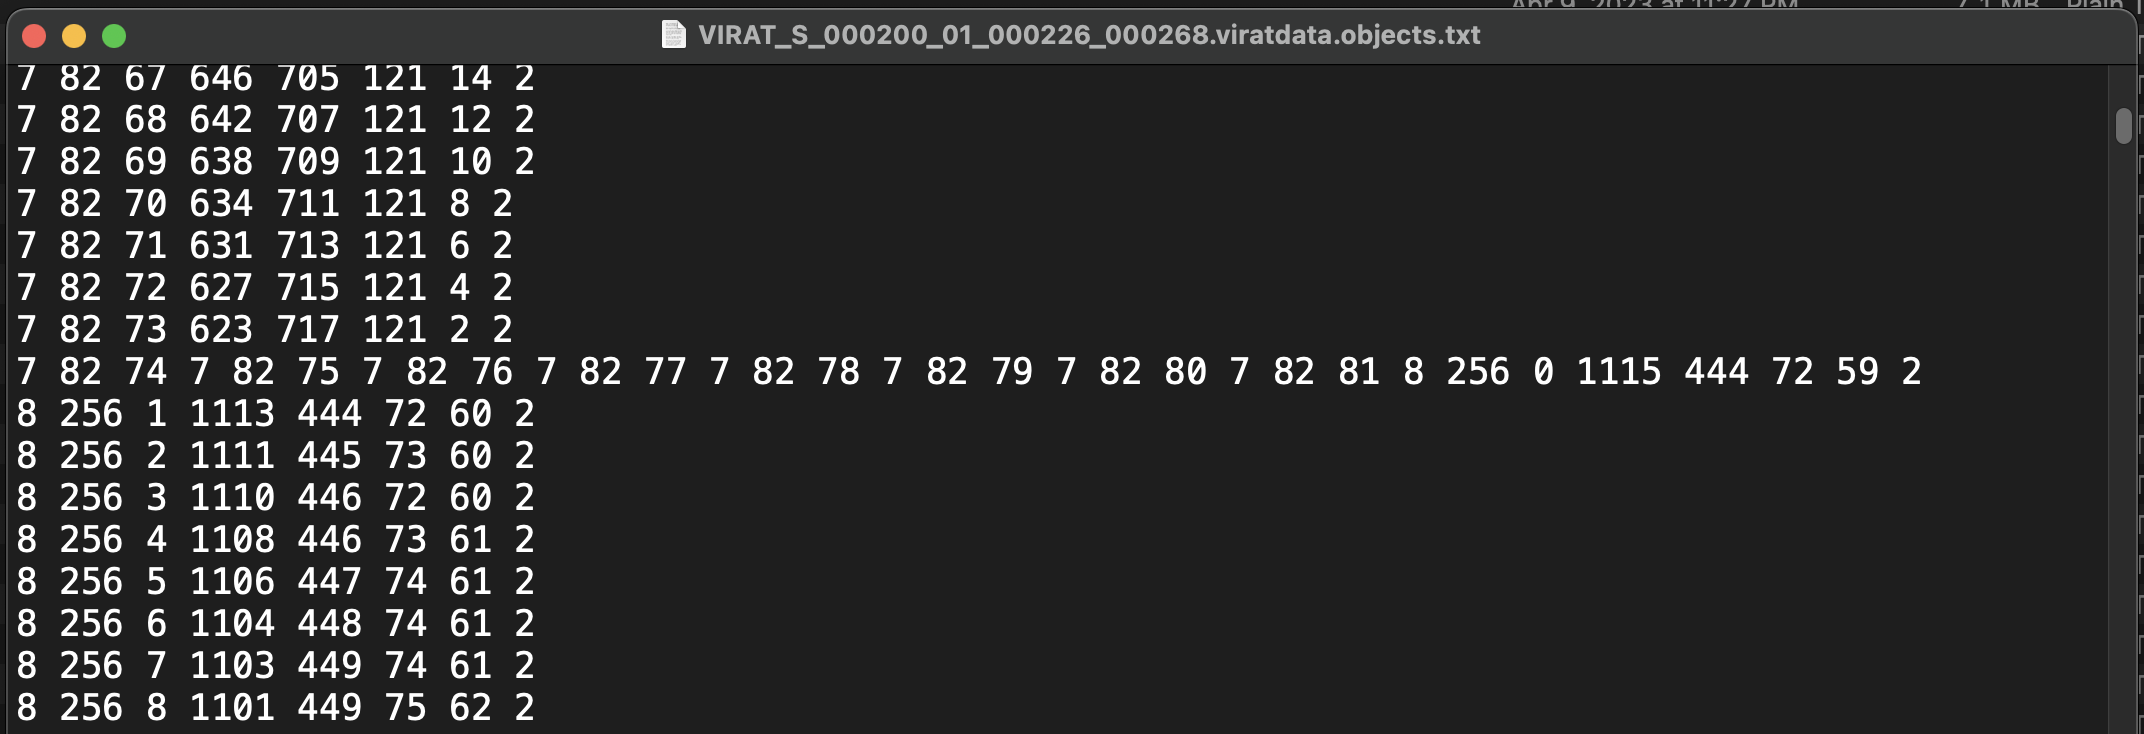

After:

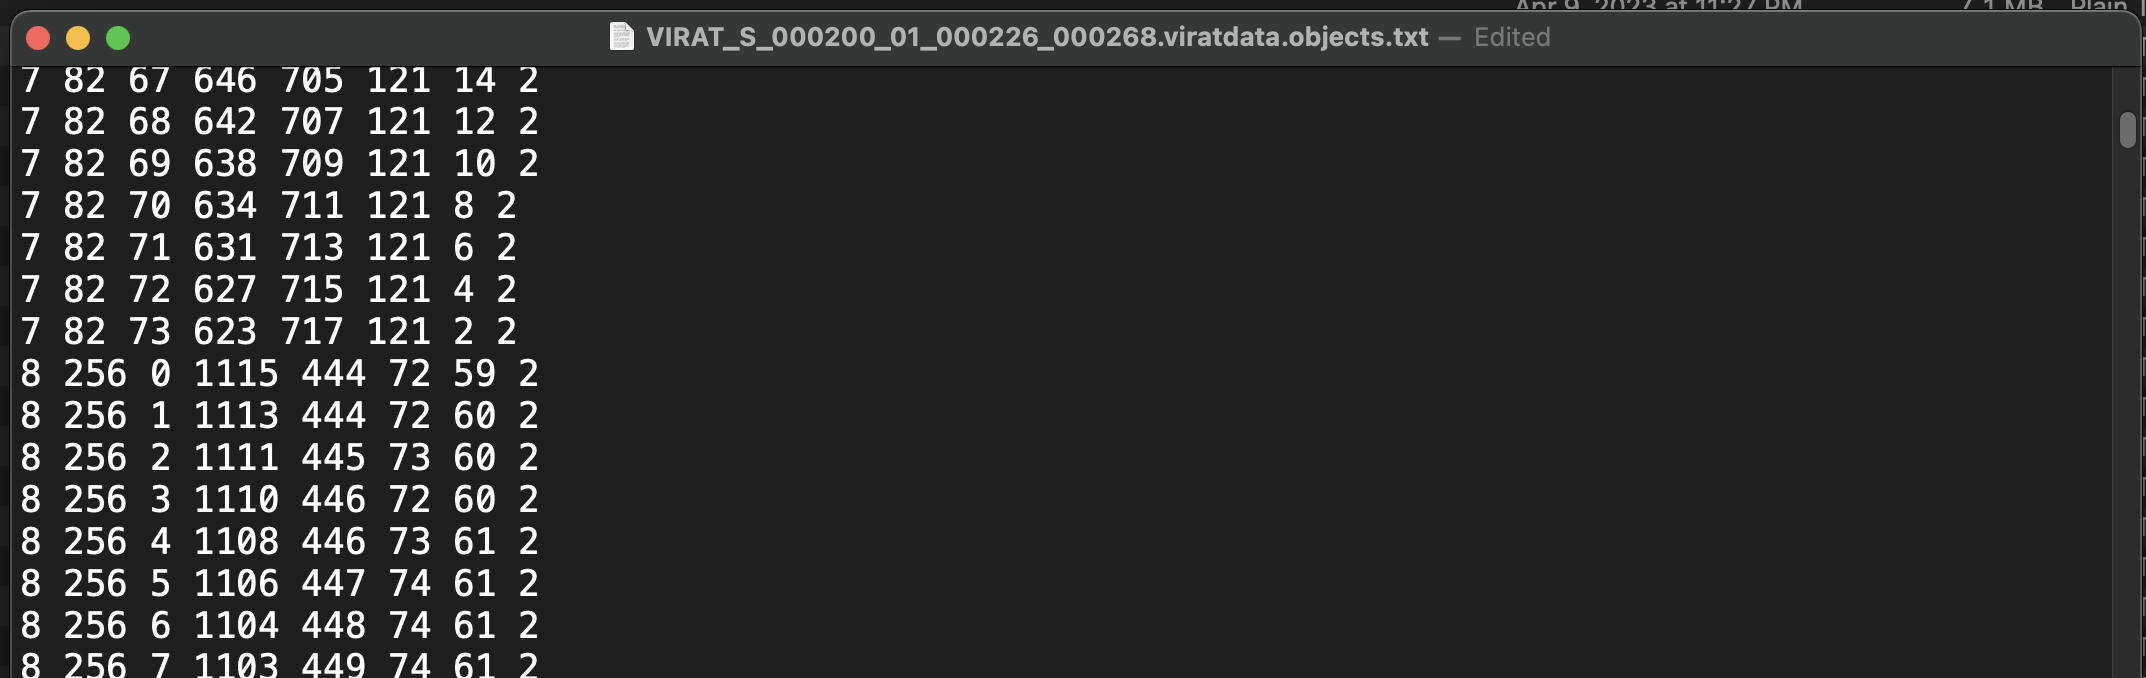

The following were modified in similar fashion to the above:

['/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000200_01_000226_000268.viratdata.objects.txt',
 '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_000206_09_001714_001851.viratdata.objects.txt',
 '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_050201_07_001348_001458.viratdata.objects.txt',
 '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_050203_07_001288_001531.viratdata.objects.txt',
 '/Users/p/Documents/Code/VIRAT/VIRAT Ground Dataset/annotations/VIRAT_S_050203_09_001960_002083.viratdata.objects.txt']

### Summary

- 329 total videos
- 14 videos don't have corresponding objects.txt file
- 5 + 1 objects.txt files are corrupted in some way that requires cleaning (1 already cleaned)
- 5 object.txt files with "Object_Type" == 0 objects. These which appear to be mistakes. Or, Possibly used for Events? Need to look into this.

### View sample of the type-0 objects

In [40]:
for i in type0s:
    # get video and object paths
    video_suffix = all_keys[key_list[i]][0]
    object_suffix = all_keys[key_list[i]][1]
    video_path = vid_prefix + video_suffix
    # if the object file doesn't exist for this video, print failure
    if object_suffix == None:
        print("*** VIDEO HAS NO MATCHED OBJECT FILE: ", video_suffix)
    else:
        object_path = obj_prefix + object_suffix
        try:
            # get dataframe from object path
            df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
            # list unique IDs of objects with type 0
            type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
    
            # print where we are
            print(video_suffix)
            print(object_suffix)

            # view these objects in turn
            type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
            for obj in type0_objs:
                display_this_object_ff(obj, df_obj)

        # if there was some issue with handling the data in a pandas dataframe
        except:
            print("*** FAILED TO EXTRACT DATA: ", object_suffix)

VIRAT_S_000001.mp4
VIRAT_S_000001.viratdata.objects.txt
Object_ID:  26
Current_Frame:  0
Object_ID:  27
Current_Frame:  0
Object_ID:  28
Current_Frame:  0
Object_ID:  29
Current_Frame:  0
Object_ID:  30
Current_Frame:  110
Object_ID:  31
Current_Frame:  0
VIRAT_S_000002.mp4
VIRAT_S_000002.viratdata.objects.txt
Object_ID:  14
Current_Frame:  0
Object_ID:  15
Current_Frame:  0
Object_ID:  16
Current_Frame:  0
Object_ID:  17
Current_Frame:  0
Object_ID:  18
Current_Frame:  0
Object_ID:  19
Current_Frame:  0
Object_ID:  20
Current_Frame:  0
Object_ID:  21
Current_Frame:  0
VIRAT_S_000003.mp4
VIRAT_S_000003.viratdata.objects.txt
Object_ID:  15
Current_Frame:  0
Object_ID:  16
Current_Frame:  0
Object_ID:  17
Current_Frame:  0
Object_ID:  18
Current_Frame:  0
Object_ID:  19
Current_Frame:  0
Object_ID:  20
Current_Frame:  0
Object_ID:  21
Current_Frame:  0
Object_ID:  22
Current_Frame:  0
Object_ID:  23
Current_Frame:  0
VIRAT_S_000206_07_001501_001600.mp4
VIRAT_S_000206_07_001501_001600.vir

### Next Steps

Clean it up by:
1. Getting rid of Object_Type == 0 data in objects.txt files
2. Getting rid of Videos without corresponding Object files (research permitting, need to see if they are used for events)
3. (Begun, below) Look at some samples of boxed objects, per object type, make sure that boxing makes sense

### Look at some samples of boxed objects, per object type, make sure that boxing makes sense

In [41]:
type0s

[0, 1, 2, 37, 302, 312, 314]

In [42]:
# Observe some type-1 objects --> "people"
obj_type = 1

for i in type0s:
    # get video and object paths
    video_suffix = all_keys[key_list[i]][0]
    object_suffix = all_keys[key_list[i]][1]
    video_path = vid_prefix + video_suffix
    # if the object file doesn't exist for this video, print failure
    if object_suffix == None:
        print("*** VIDEO HAS NO MATCHED OBJECT FILE: ", video_suffix)
    else:
        object_path = obj_prefix + object_suffix
        try:
            # get dataframe from object path
            df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
            # list unique IDs of objects with type 0
            type0_objs = df_obj[df_obj['Object_Type'] == 0]['Object_ID'].unique()
    
            # print where we are
            print(video_suffix)
            print(object_suffix)

            # view these objects in turn
            type0_objs = df_obj[df_obj['Object_Type'] == obj_type]['Object_ID'].unique()
            for obj in type0_objs:
                """
                display_this_object_ff(obj, df_obj) # This takes FOREVER. bad design.
                """

        # if there was some issue with handling the data in a pandas dataframe
        except:
            print("*** FAILED TO EXTRACT DATA: ", object_suffix)

VIRAT_S_000001.mp4
VIRAT_S_000001.viratdata.objects.txt
Object_ID:  1
Current_Frame:  3455
Object_ID:  4
Current_Frame:  3591
Object_ID:  10
Current_Frame:  9635
Object_ID:  13
Current_Frame:  15856
Object_ID:  18
Current_Frame:  16938
Object_ID:  19
Current_Frame:  3691
Object_ID:  20
Current_Frame:  3694
Object_ID:  21
Current_Frame:  5617
Object_ID:  22
Current_Frame:  5617
Object_ID:  23
Current_Frame:  5768
Object_ID:  25
Current_Frame:  6114
VIRAT_S_000002.mp4
VIRAT_S_000002.viratdata.objects.txt
Object_ID:  2
Current_Frame:  0
Object_ID:  3
Current_Frame:  0
Object_ID:  4
Current_Frame:  0
Object_ID:  6
Current_Frame:  2544
Object_ID:  7
Current_Frame:  2629
*** FAILED TO EXTRACT DATA:  VIRAT_S_000002.viratdata.objects.txt
VIRAT_S_000003.mp4
VIRAT_S_000003.viratdata.objects.txt
Object_ID:  3
Current_Frame:  5147
Object_ID:  4
Current_Frame:  3928
Object_ID:  7
Current_Frame:  10468
Object_ID:  9
Current_Frame:  12266
Object_ID:  12
Current_Frame:  15922
Object_ID:  13
Current_Fr

In [43]:
randomlist = random.sample(range(0, 330), 5)
randomlist

[219, 250, 156, 181, 213]

In [44]:
# Observe some type-1 objects --> 
obj_type = 1

for i in randomlist:
    # get video and object paths
    video_suffix = all_keys[key_list[i]][0]
    object_suffix = all_keys[key_list[i]][1]
    video_path = vid_prefix + video_suffix
    # if the object file doesn't exist for this video, print failure
    if object_suffix == None:
        print("*** VIDEO HAS NO MATCHED OBJECT FILE: ", video_suffix)
    else:
        object_path = obj_prefix + object_suffix
        try:
            # get dataframe from object path
            df_obj = pd.read_csv(object_path, sep=" ", names=object_columns, index_col=False)
            # list unique IDs of objects with type 0
            type0_objs = df_obj[df_obj['Object_Type'] == obj_type]['Object_ID'].unique()
    
            # print where we are
            print(video_suffix)
            print(object_suffix)

            # view these objects in turn
            type0_objs = df_obj[df_obj['Object_Type'] == obj_type]['Object_ID'].unique()
            for obj in type0_objs:
                """
                display_this_object_ff(obj, df_obj) # THIS TAKES FOREVER.... Bad design.
                """
                
        # if there was some issue with handling the data in a pandas dataframe
        except:
            print("*** FAILED TO EXTRACT DATA: ", object_suffix)

VIRAT_S_010208_03_000201_000232.mp4
VIRAT_S_010208_03_000201_000232.viratdata.objects.txt
Object_ID:  0
Current_Frame:  0
Object_ID:  1
Current_Frame:  0
Object_ID:  2
Current_Frame:  80
Object_ID:  3
Current_Frame:  51
Object_ID:  5
Current_Frame:  231
Object_ID:  6
Current_Frame:  0
Object_ID:  7
Current_Frame:  0
Object_ID:  8
Current_Frame:  241
Object_ID:  9
Current_Frame:  300
Object_ID:  10
Current_Frame:  0
Object_ID:  11
Current_Frame:  300
Object_ID:  12
Current_Frame:  315
Object_ID:  13
Current_Frame:  0
Object_ID:  14
Current_Frame:  80
Object_ID:  15
Current_Frame:  0
Object_ID:  16
Current_Frame:  0
Object_ID:  17
Current_Frame:  300
Object_ID:  18
Current_Frame:  365
Object_ID:  19
Current_Frame:  381
*** FAILED TO EXTRACT DATA:  VIRAT_S_010208_03_000201_000232.viratdata.objects.txt
VIRAT_S_040005_00_000003_000058.mp4
VIRAT_S_040005_00_000003_000058.viratdata.objects.txt
Object_ID:  4
Current_Frame:  321
Object_ID:  6
Current_Frame:  300
Object_ID:  8
Current_Frame:  32

### Clean Up Functions for ease of use

1. view_video_bb(path, scrub) --> pass video_path and point to jump to (0-9, 0 for start, 9 for end)